<a href="https://colab.research.google.com/github/LJ1201/MSDS-490-Bank_Campaign/blob/main/BankMkting_clustering_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import packages

In [76]:
# pip install gower

In [77]:
# pip install kneed

In [78]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering algorithm
from sklearn.cluster import AgglomerativeClustering

# Rand Index
from sklearn.metrics.cluster import rand_score

# Encode labels
from sklearn import preprocessing


import gower

# Kmeans method
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## Import dataset

Data Source: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


##Attribute Information:

Input variables:

#Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')



Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)


17 - cons.price.idx: consumer price index - monthly indicator (numeric)


18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)


19 - euribor3m: euribor 3 month rate - daily indicator (numeric)


20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):


21 - y - has the client subscribed a term deposit? (binary: 'yes','no')




#Relevant Papers:

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS. [bank.zip]



In [79]:
url = 'https://raw.githubusercontent.com/LJ1201/MSDS-490-Bank_Campaign/main/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

In [80]:
data_full = data.copy()
data_full = data.drop(['duration'],axis = 1)

In [81]:
np.random.seed(42)

In [82]:
data_full_yes = data_full[data_full['y'] == 'yes']
data_full_no = data_full[data_full['y'] == 'no']

In [83]:
data_full_no = data_full_no.sample(frac = 0.3)

In [84]:
data_full_sample = pd.concat([data_full_yes, data_full_no], sort=False)

In [85]:
data_full_sample = data_full_sample.reset_index()
data_full_sample = data_full_sample.drop(['index'], axis = 1)

In [86]:
# data_full_yes = data_full_yes.reset_index()

In [87]:
# data_full_yes= data_full_yes.drop(['index'], axis = 1)

In [88]:
# target = data_full_yes[['y']]
# data_no_target = data_full_yes.drop(['y'],axis=1)
# data_no_target.head()

In [89]:
target = data_full_sample[['y']]
data_no_target = data_full_sample.drop(['y'],axis=1)
data_no_target.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,49,technician,married,basic.9y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [90]:
data_no_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15604 entries, 0 to 15603
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             15604 non-null  int64  
 1   job             15604 non-null  object 
 2   marital         15604 non-null  object 
 3   education       15604 non-null  object 
 4   default         15604 non-null  object 
 5   housing         15604 non-null  object 
 6   loan            15604 non-null  object 
 7   contact         15604 non-null  object 
 8   month           15604 non-null  object 
 9   day_of_week     15604 non-null  object 
 10  campaign        15604 non-null  int64  
 11  pdays           15604 non-null  int64  
 12  previous        15604 non-null  int64  
 13  poutcome        15604 non-null  object 
 14  emp.var.rate    15604 non-null  float64
 15  cons.price.idx  15604 non-null  float64
 16  cons.conf.idx   15604 non-null  float64
 17  euribor3m       15604 non-null 

In [91]:
data_no_target.nunique()

age                75
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           35
pdays              26
previous            7
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         302
nr.employed        11
dtype: int64

In [92]:
data_no_target_trans = data_no_target.copy()

##Numeric Variables Transform

Age

In [93]:
data_no_target_trans['age'] = data_no_target_trans['age']//10

In [94]:
data_no_target_trans.nunique()

age                 9
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           35
pdays              26
previous            7
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         302
nr.employed        11
dtype: int64

In [95]:
data_no_target_trans.head().T

,0,1,2,3,4
age,4,4,4,4,4
job,blue-collar,entrepreneur,technician,technician,blue-collar
marital,divorced,married,married,married,married
education,basic.4y,university.degree,basic.9y,professional.course,basic.9y
default,unknown,unknown,no,unknown,unknown
housing,yes,yes,no,yes,yes
loan,no,no,no,no,no
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


Campaign

class 11 : >10

In [96]:
for i in range(0, len(data_no_target_trans)):
  if data_no_target_trans['campaign'][i] > 10:
    data_no_target_trans['campaign'][i] = 11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Pdays into Pweeks

In [97]:
data_no_target_trans['pweeks'] =data_no_target_trans['pdays']

In [98]:
for i in range(0, len(data_no_target_trans)):
  if data_no_target_trans['pweeks'][i] <=28:
    data_no_target_trans['pweeks'][i] = data_no_target_trans['pweeks'][i] // 7
  elif data_no_target_trans['pweeks'][i] >28:
    data_no_target_trans['pweeks'][i] = 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
data_no_target_trans = data_no_target_trans.drop(['pdays'], axis = 1)

euribor3m - euribor 3 month rate

class 1 : [1,2)

class 2 : [2,3)

class 3 : [3,4)

class 4 : [4,5)

class 5 : [5,)

In [100]:
for i in range(0,len(data_no_target_trans)):
  if (data_no_target_trans['euribor3m'][i] >= 0) & (data_no_target_trans['euribor3m'][i] < 1) :
    data_no_target_trans['euribor3m'][i] ='1'
  elif (data_no_target_trans['euribor3m'][i] > 1 ) and (data_no_target_trans['euribor3m'][i] < 2) :
    data_no_target_trans['euribor3m'][i] ='2'
  elif (data_no_target_trans['euribor3m'][i] >= 2) and (data_no_target_trans['euribor3m'][i] < 3) :
    data_no_target_trans['euribor3m'][i] ='3'
  elif (data_no_target_trans['euribor3m'][i] >= 3) and (data_no_target_trans['euribor3m'][i] < 4) :
    data_no_target_trans['euribor3m'][i] ='4'
  elif (data_no_target_trans['euribor3m'][i] >= 4) :
    data_no_target_trans['euribor3m'][i] ='5'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python

cons.price.idx

class 1 : [92, 93)

class 2 : [93, 94)

class 3 : [94,) 

In [101]:
for i in range(0,len(data_no_target_trans)):
  if (data_no_target_trans['cons.price.idx'][i] >= 92) & (data_no_target_trans['cons.price.idx'][i] < 93) :
    data_no_target_trans['cons.price.idx'][i] = 1
  elif (data_no_target_trans['cons.price.idx'][i] >= 93 ) and (data_no_target_trans['cons.price.idx'][i] < 94) :
    data_no_target_trans['cons.price.idx'][i] = 2
  elif (data_no_target_trans['cons.price.idx'][i] >= 94) :
    data_no_target_trans['cons.price.idx'][i] = 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


cons.conf.idx

class 1 : >= 40

class 2 : <40 

In [102]:
for i in range(0,len(data_no_target_trans)):
  if (data_no_target_trans['cons.conf.idx'][i] >= 40)  :
    data_no_target_trans['cons.conf.idx'][i] = '1'
  elif (data_no_target_trans['cons.conf.idx'][i] <40 ) :
    data_no_target_trans['cons.conf.idx'][i] ='2'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [103]:
data_no_target_trans.nunique()

age                9
job               12
marital            4
education          8
default            3
housing            3
loan               3
contact            2
month             10
day_of_week        5
campaign          11
previous           7
poutcome           3
emp.var.rate      10
cons.price.idx     3
cons.conf.idx      1
euribor3m          4
nr.employed       11
pweeks             5
dtype: int64

In [148]:
data_no_target_trans_test = data_no_target_trans.copy()

In [149]:
data_no_target_trans_test.shape

(15604, 19)

##K means clustering

In [150]:
data_no_target_trans_test_1 = data_no_target_trans_test.copy()

In [151]:
# !pip install kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 127275.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 127275.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 127275.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 127275.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 127275.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2171, cost: 115735.0
Run 1, iteration: 2/100, moves: 2078, cost: 114289.0
Run 1, iteration: 3/100, moves: 126, cost: 114289.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, ite

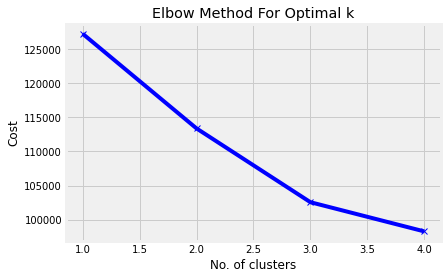

In [152]:
# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(data_no_target_trans_test_1)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [108]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data_no_target_trans_test_1)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3152, cost: 110526.0
Run 1, iteration: 2/100, moves: 324, cost: 110526.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5377, cost: 111593.0
Run 2, iteration: 2/100, moves: 2008, cost: 111032.0
Run 2, iteration: 3/100, moves: 1297, cost: 110161.0
Run 2, iteration: 4/100, moves: 980, cost: 109880.0
Run 2, iteration: 5/100, moves: 153, cost: 109880.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3710, cost: 105662.0
Run 3, iteration: 2/100, moves: 1037, cost: 105662.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6035, cost: 111439.0
Run 4, iteration: 2/100, moves: 719, cost: 111439.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/1

array([1, 1, 1, ..., 0, 1, 1], dtype=uint16)

In [111]:
len(data_no_target_trans_test_1.columns)

19

In [112]:
data_no_target_trans_test_1.insert(19, "Cluster", clusters, True)


In [117]:
data_no_target_trans_test_1['Cluster'].value_counts()

0    5809
1    5609
2    4186
Name: Cluster, dtype: int64

In [113]:
data_no_target_trans_test_1.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pweeks,Cluster
0,4,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,1,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1
1,4,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,1,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1
2,4,technician,married,basic.9y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1
3,4,technician,married,professional.course,unknown,yes,no,telephone,may,mon,1,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1
4,4,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,1,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1


In [114]:
data_no_target_trans_test_1['y'] = target

In [123]:
data_no_target_trans_test_1.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pweeks,Cluster,y
0,4,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1,yes
1,4,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1,yes
2,4,technician,married,basic.9y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1,yes
3,4,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1,yes
4,4,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,1,yes


In [146]:
df = data_no_target_trans_test_1.groupby(['Cluster','y'])['y'].count()

In [147]:
df

Cluster  y  
0        no     2964
         yes    2845
1        no     4730
         yes     879
2        no     3270
         yes     916
Name: y, dtype: int64

# Building the model with 2 clusters

In [162]:
data_no_target_trans_test_2 = data_no_target_trans_test.copy()

In [154]:
# Building the model with 2 clusters
kmode = KModes(n_clusters=2, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data_no_target_trans_test_2)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1000, cost: 113941.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4997, cost: 113384.0
Run 2, iteration: 2/100, moves: 1809, cost: 113384.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3057, cost: 117744.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2059, cost: 116717.0
Run 4, iteration: 2/100, moves: 1111, cost: 116125.0
Run 4, iteration: 3/100, moves: 5, cost: 116125.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1897, cost: 113331.0
Best run was number 5


array([0, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [163]:
data_no_target_trans_test_2.insert(19, "Cluster", clusters, True)

In [164]:
data_no_target_trans_test_2['y'] = target

In [165]:
data_no_target_trans_test_2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pweeks,Cluster,y
0,4,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,0,yes
1,4,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,0,yes
2,4,technician,married,basic.9y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,0,yes
3,4,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,0,yes
4,4,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,0,nonexistent,1.1,2.0,2.0,5.0,5191.0,5,0,yes


In [166]:
df_2 = data_no_target_trans_test_2.groupby(['Cluster','y'])['y'].count()

In [169]:
df_2

Cluster  y  
0        no     8225
         yes    2247
1        no     2739
         yes    2393
Name: y, dtype: int64

In [170]:
df_2[0][0]

8225

In [171]:
df_2[0][1]

2247

In [172]:
True_neg = df_2[0][0]
False_pos = df_2[0][1]
True_pos = df_2[1][1]
False_neg = df_2[1][0]

accuracy = (True_neg + True_pos)/(True_neg + False_neg + True_pos + False_pos)
recall = (True_pos)/(False_neg+True_pos)
precision = (True_pos)/(False_pos + True_pos)
F1_score = 2 * ((precision*recall)/(precision+recall))

In [173]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1_score: {F1_score}')

Accuracy: 0.6804665470392207
Recall: 0.4662899454403741
Precision: 0.5157327586206897
F1_score: 0.4897666803110929
